In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
data = pd.read_csv("input/train.csv")
data_test = pd.read_csv("input/test.csv")

In [97]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_train = data.T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [99]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [100]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [101]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[4 4 4 ... 9 0 1] [2 5 8 ... 7 1 4]
0.08711904761904762
Iteration:  10
[7 4 4 ... 9 7 1] [2 5 8 ... 7 1 4]
0.10964285714285714
Iteration:  20
[7 4 4 ... 9 7 1] [2 5 8 ... 7 1 4]
0.14252380952380952
Iteration:  30
[7 4 4 ... 9 7 2] [2 5 8 ... 7 1 4]
0.1785
Iteration:  40
[7 4 4 ... 9 1 2] [2 5 8 ... 7 1 4]
0.21654761904761904
Iteration:  50
[4 4 4 ... 7 1 2] [2 5 8 ... 7 1 4]
0.2545
Iteration:  60
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.29064285714285715
Iteration:  70
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.327
Iteration:  80
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.37057142857142855
Iteration:  90
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.4192142857142857
Iteration:  100
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.4622380952380952
Iteration:  110
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.49902380952380954
Iteration:  120
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.5347380952380952
Iteration:  130
[4 7 8 ... 7 1 2] [2 5 8 ... 7 1 4]
0.5673571428571429
Iteration:  140
[4 7 8 ... 7 1 2] [2 5 8 ... 7 

In [102]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


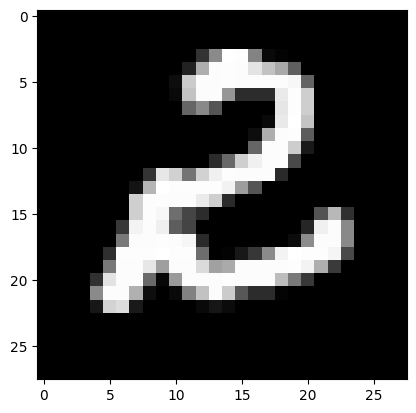

Prediction:  [0]
Label:  5


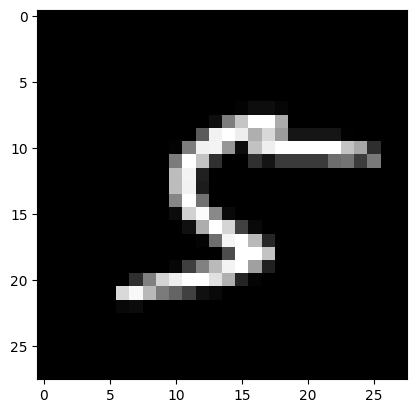

Prediction:  [3]
Label:  8


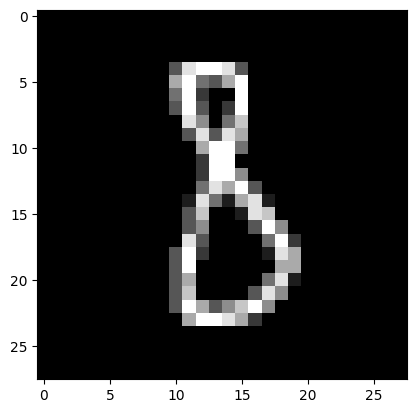

Prediction:  [6]
Label:  2


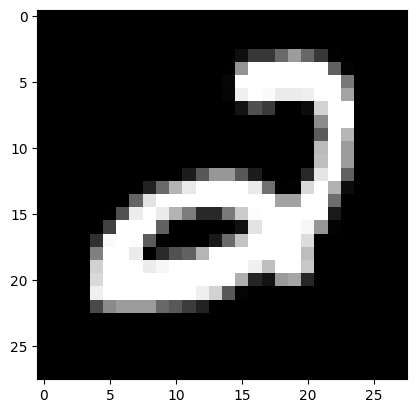

In [103]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)